In [1]:
import os
import pandas as pd
from IPython.display import display
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
import pickle 

from MyTransformers import *
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#%config Completer.use_jedi = False
%matplotlib inline  

f_data_path = "PrepedData/"
f_modele_path = 'Model/'

f_HHData = f_data_path + 'HHDataId/'
mode_path = "Models/"

In [2]:
data = pd.read_feather(f_data_path + "LPG-Profile-4.feather")
data = data['energy'].values
data = np.sum(data.reshape(-1,120),axis=1)
lag = 12*7
init = data[:lag]
#data = data[lag:] - data[:-lag]

In [5]:
def diffInvers(a):
    cc = np.empty(len(a)+lag)
    for i in range(lag):
        cc[i::lag] = np.cumsum(np.concatenate([[init[i]],a[i::lag]]))
    return cc

In [4]:
trainLen = len(data)-200
predLen = 24
train = data[:trainLen]
test = data[trainLen:trainLen+predLen]

## Seasonal

In [42]:
model = ExponentialSmoothing(train,seasonal='mul',seasonal_periods=12*7).fit()
pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)

c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [37]:
model = ExponentialSmoothing(
    train,
    seasonal_periods=12*7,
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()
pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)


In [7]:
prev = model.predict(start=0,end=trainLen).reshape(-1,1)

In [35]:
model.level

array([0.73525143, 0.73478368, 0.73433662, ..., 0.69725356, 0.69794313,
       0.69402881])

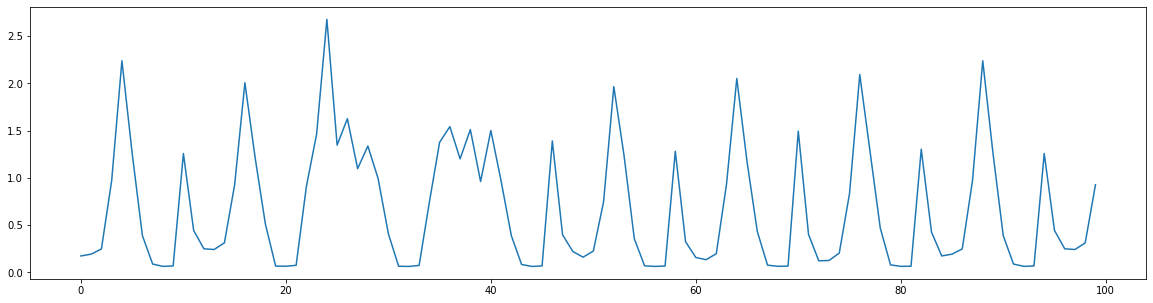

In [31]:
x = model.predict(start=trainLen+1,end=trainLen+100)
plt.plot(x)
with open('Results/expsmootPred100.npy','wb') as f:
    np.save(f,x)

In [30]:
with open('Results/expsmootEndog.npy','wb') as f:
    np.save(f,model.data.endog)

In [12]:
model.params

{'smoothing_level': 0.02242732830031289,
 'smoothing_trend': nan,
 'smoothing_seasonal': 4.93552304628974e-08,
 'damping_trend': nan,
 'initial_level': 0.7360047690491268,
 'initial_trend': nan,
 'initial_seasons': array([-0.61733107, -0.62938417, -0.62722512,  0.80063055, -0.29192828,
        -0.57103026, -0.56761676, -0.48905939,  0.14003335,  1.40010126,
         0.58676564, -0.22433257, -0.61404854, -0.62983029, -0.62845976,
         0.60991498, -0.26795383, -0.519875  , -0.50052507, -0.4456927 ,
         0.27700506,  1.54605526,  0.56673454, -0.30492657, -0.60546233,
        -0.63005357, -0.62554879,  0.56411956, -0.24986267, -0.44443702,
        -0.45150611, -0.38137487,  0.23363538,  1.31291845,  0.51956564,
        -0.18239232, -0.62723698, -0.62871455, -0.61882172,  0.21556779,
         0.7707258 ,  1.98389018,  0.65294392,  0.93290497,  0.40393486,
         0.6433563 ,  0.29817115, -0.28370082, -0.62885701, -0.63079478,
        -0.62002564,  0.04816734,  0.68313293,  0.848659

## Simple

In [79]:
model = SimpleExpSmoothing(train).fit()
pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)

## Test

In [9]:
# ipred = diffInvers(pred.flatten())[lag:]
# itest = diffInvers(test.flatten())[lag:]
ipred = pred
itest = test
mean_squared_error(itest,ipred), mean_absolute_percentage_error(itest,ipred)

(0.5183518896365312, 0.6051866937982656)

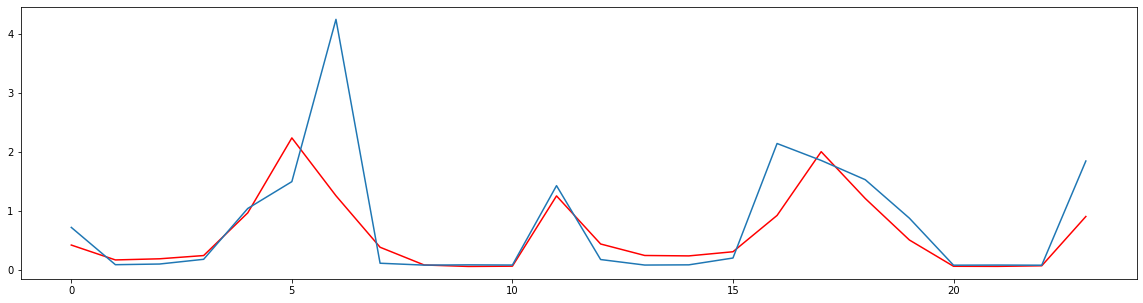

In [10]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ipred,'r')
plt.plot(itest)

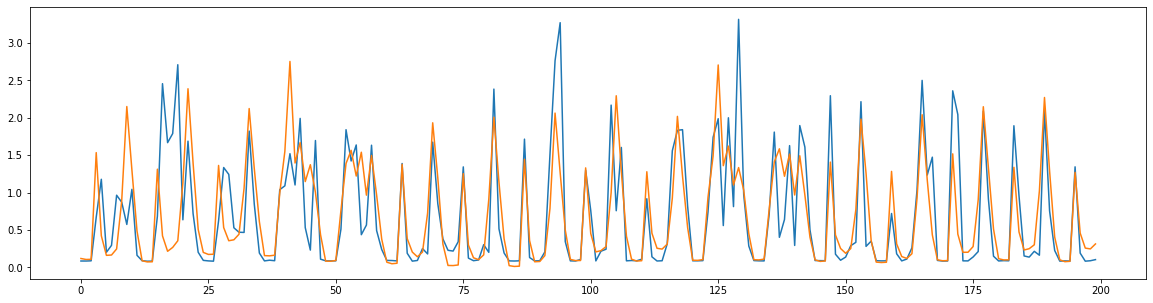

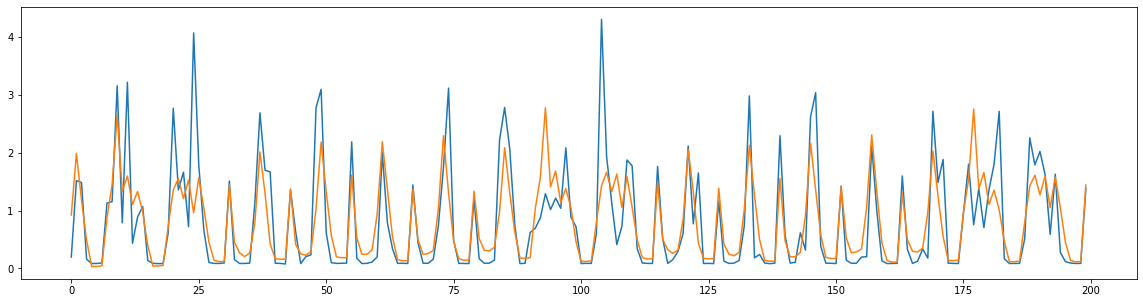

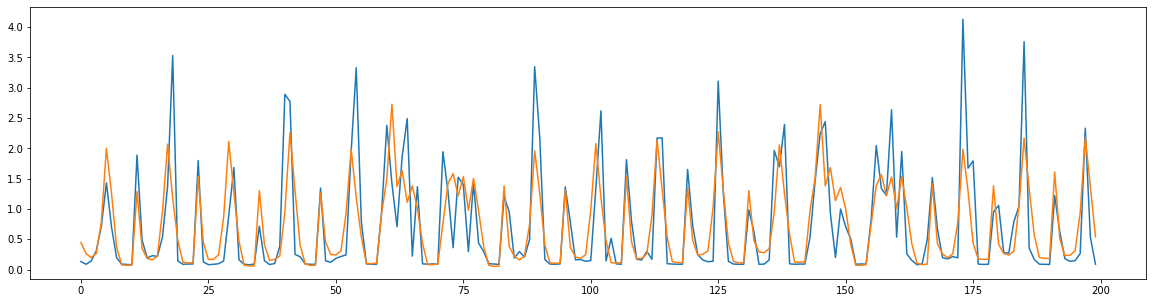

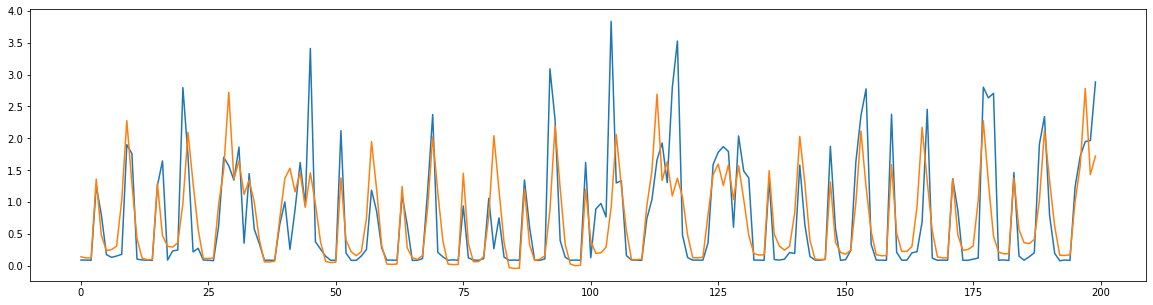

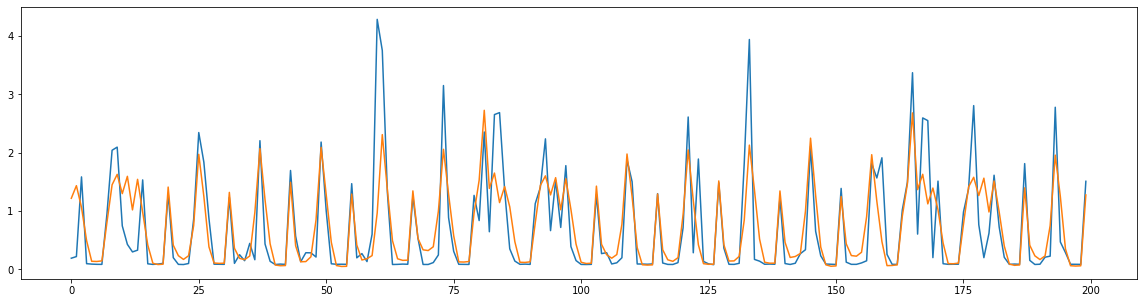

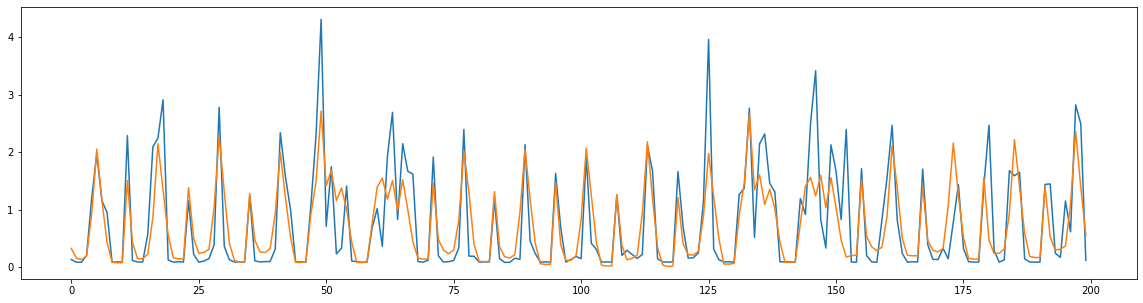

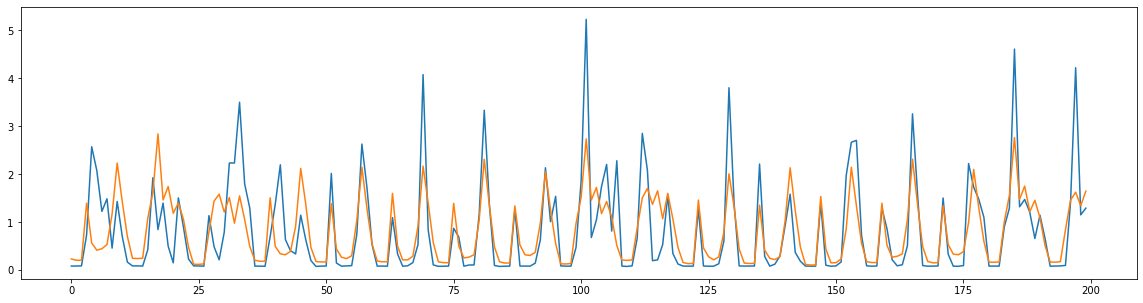

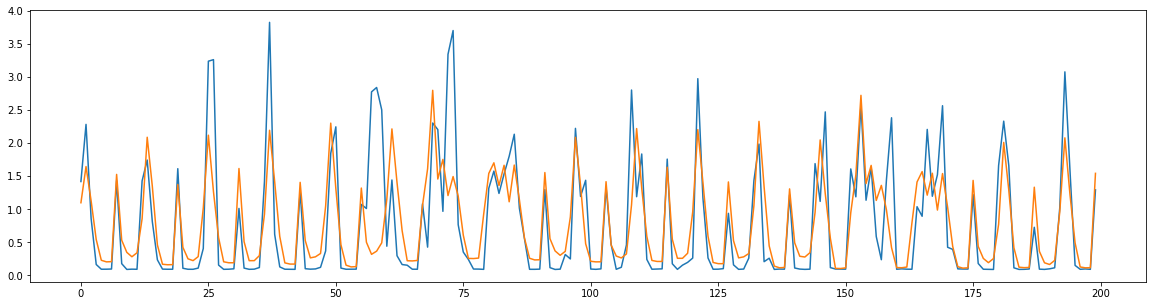

<Figure size 1440x360 with 0 Axes>

In [11]:
# iprev = diffInvers(prev.flatten())[lag:]
# itrain = diffInvers(train.flatten())[lag:]
iprev = prev
itrain = train
for i in range(0,1600,200):
    plt.plot(itrain[i:i+200])
    plt.plot(iprev[i:i+200])
    plt.figure()